# Example Ising Model

This is from the following video: https://youtube.com/watch?v=K--1hlv9yv0&feature=share

Hopefully, this will provide a useful guide for us moving forward.

In [ ]:
# we will make a 50x50 grid
N = 50

In [92]:
# +1 is spin up
# - 1 is spin down
init_random = np.random.random((N,N,N))
lattice_n = np.zeros((N, N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N,N))
lattice_p = np.zeros((N, N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

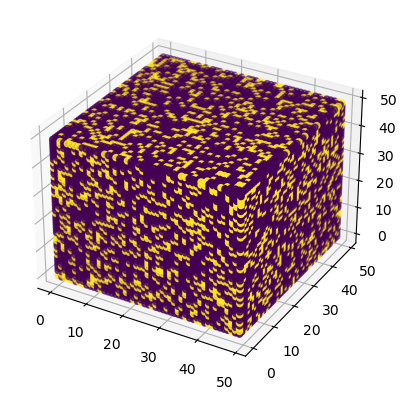

In [93]:
# plot the initial state of lattice_n

fig = plt.figure()
ax = plt.axes(projection='3d')
x, y, z = np.meshgrid(np.arange(lattice_n.shape[0]), np.arange(lattice_n.shape[1]), np.arange(lattice_n.shape[2]))
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=lattice_n.ravel())

plt.show()

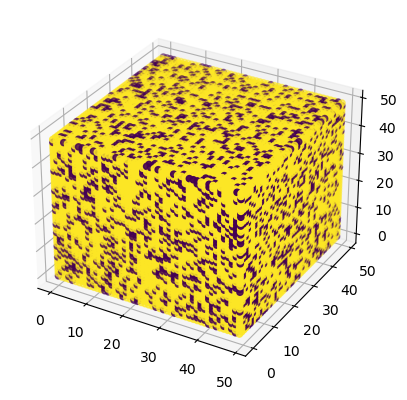

In [89]:
# plot the initial state of lattice_p

fig = plt.figure()
ax = plt.axes(projection='3d')
x, y, z = np.meshgrid(np.arange(lattice_p.shape[0]), np.arange(lattice_p.shape[1]), np.arange(lattice_p.shape[2]))
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=lattice_p.ravel())

plt.show()

In [96]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1) 
    kern[1][1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # print(kern)
    return 0.5*arr.sum()

In [97]:
print(get_energy(lattice_p))
print(get_energy(lattice_n))

-90762.0
-92856.0


In [125]:
# @numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)

# spin_arr = the array of the lattice +1, -1
# 
def metropolis(spin_arr, times, BJ, energy):
    # spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        z = np.random.randint(0,N)
        spin_i = spin_arr[x,y,z]    # initial spin
        spin_f = spin_i*-1          # proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y,z]
            E_f += -spin_f*spin_arr[x-1,y,z]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y,z]
            E_f += -spin_f*spin_arr[x+1,y,z]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1,z]
            E_f += -spin_f*spin_arr[x,y-1,z]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1,z]
            E_f += -spin_f*spin_arr[x,y+1,z]
        if z>0:
            E_i += -spin_i*spin_arr[x,y,z-1]
            E_f += -spin_f*spin_arr[x,y,z-1]
        if z<N-1:
            E_i += -spin_i*spin_arr[x,y,z+1]
            E_f += -spin_f*spin_arr[x,y,z+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y,z] = spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y,z]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    # print(net_energy[-1])
    return net_spins, net_energy           

In [100]:
# print(lattice_n)

In [126]:
spins, energies = metropolis(lattice_n, 10000, 0.2, get_energy(lattice_n))

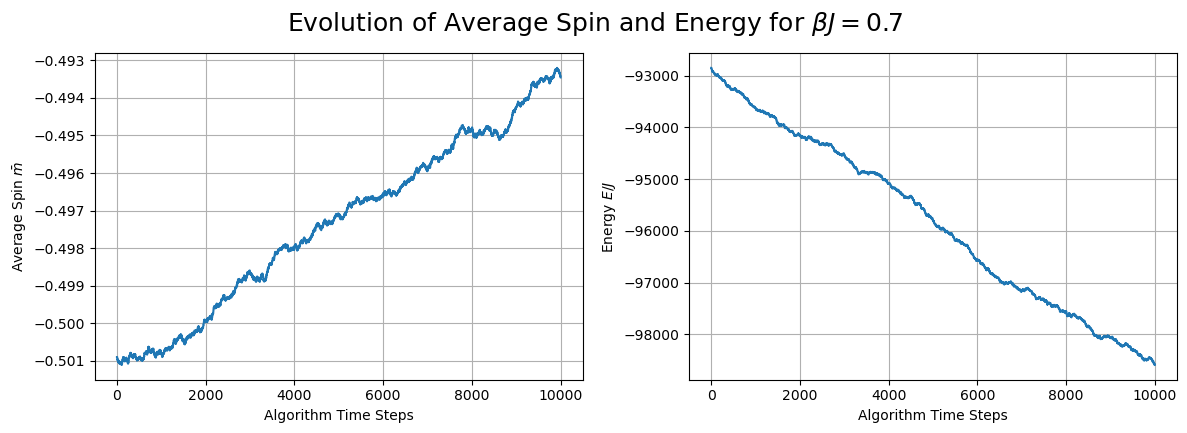

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**3)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [128]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use(['science','notebook', 'grid'])
import numba
from numba import njit 
from scipy.ndimage import convolve, generate_binary_structure
from mpl_toolkits import mplot3d
%matplotlib inline

In [129]:
def get_spin_energy(lattice, BJs):
    M = 1000
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, M, bj, get_energy(lattice))
        ms[i] = spins[-M:].mean()/N**3
        E_means[i] = energies[-M:].mean()
        E_stds[i] = energies[-M:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

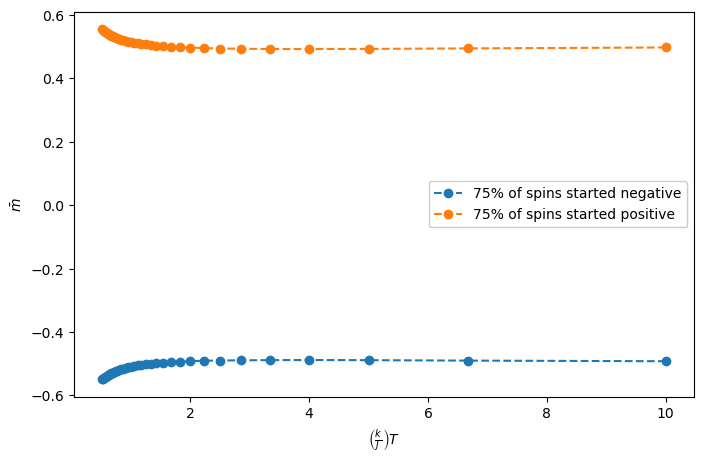

In [130]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

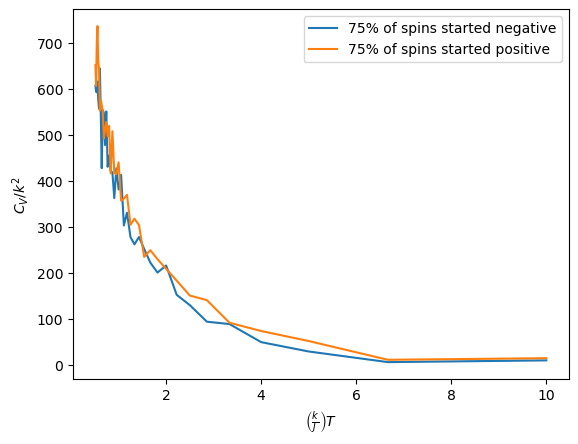

In [131]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

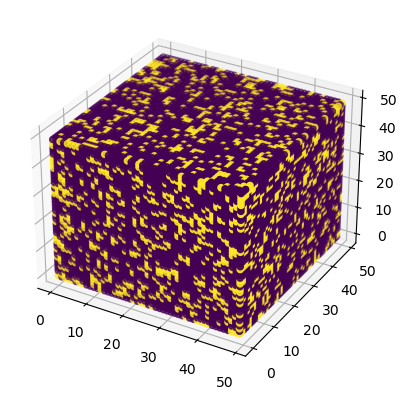

In [132]:
# plot the initial state of lattice_n

fig = plt.figure()
ax = plt.axes(projection='3d')
x, y, z = np.meshgrid(np.arange(lattice_n.shape[0]), np.arange(lattice_n.shape[1]), np.arange(lattice_n.shape[2]))
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=lattice_n.ravel())

plt.show()

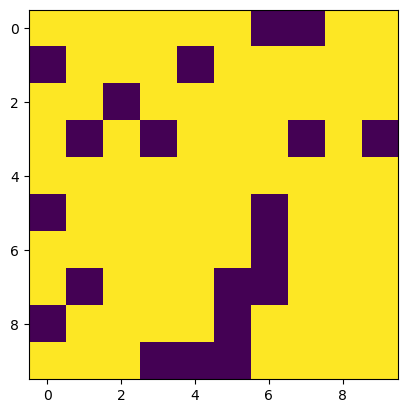

In [ ]:
plt.imshow(lattice_p)